In [126]:
# Set The PATH Here!
#push!(LOAD_PATH, "/Users/emassoud/Desktop/CLIMA/examples/Land/")
push!(LOAD_PATH, "/Users/emassoud/Desktop/JULIA/2_21_2020_LSM-SPAM-master/src/Soil/coupled_heat_moisture/")
# Include required libraries
using Plots
using Parameters
using Printf
using Soil_Physics

#=
# Load necessary CliMA subroutines
using MPI
using CLIMA
using Logging
using CLIMA.Mesh.Topologies
using CLIMA.Mesh.Grids
using CLIMA.Mesh.Elements: interpolationmatrix
using CLIMA.DGmethods
using CLIMA.DGmethods.NumericalFluxes
using CLIMA.MPIStateArrays
using CLIMA.LowStorageRungeKuttaMethod
using LinearAlgebra
using CLIMA.GenericCallbacks: EveryXWallTimeSeconds, EveryXSimulationSteps
using CLIMA.ODESolvers
ENV["GKS_ENCODING"] = "utf-8"
using Plots
gr()
=#

In [127]:
# CLIMA.init()

# include("Soil_Physics.jl")

In [128]:
# Defining the soil heat methods and grids UNITS are Important
global physcon = Soil_Physics.physcon() 
# Define the number of soil Layers
global soilvar = Soil_Physics.soilvar(nsoi=150)
# Generate the Soil Compute Grid
soilvar = Soil_Physics.compute_grid_settings_heat(soilvar)

# --- Model run control parameters

tmean = physcon.tfrz + 15.0;       # Mean daily air temperature for diurnal cycle [K]
trange = 30.0;                     # Temperature range for diurnal cycle [K]
dt = 1800;                         # Time step [seconds]
nday = 100;                        # Number of days
soilvar.soil_texture = 1;          # Soil texture class: sand
soilvar.method = "excess-heat";    # Use excess heat for phase change

#soilvar.soil_texture = 11;         # Soil texture class: clay
#soilvar.method = "apparent-heat-capacity"; # Use apparent heat capacity for phase change

In [129]:
# Initial soil temperature [K] and unfrozen & frozen water [kg H2O/m2]

for i = 1:soilvar.nsoi

   # Temperature [K]

   soilvar.tsoi[i] = physcon.tfrz + 2.0

   # Soil water at saturation [kg H2O/m2]

   h2osoi_sat = soilvar.watsat[soilvar.soil_texture] * physcon.rhowat * soilvar.dz[i]

   # Actual water content is some fraction of saturation

   if (soilvar.tsoi[i] .> physcon.tfrz)
      soilvar.h2osoi_ice[i] = 0
      soilvar.h2osoi_liq[i] = 0.8 * h2osoi_sat
   else()
      soilvar.h2osoi_liq[i] = 0
      soilvar.h2osoi_ice[i] = 0.8 * h2osoi_sat
   end

end

In [130]:
# ---  SPIN UP OF SOIL TEMPERATURE to see the diurnal cycle

# Main loop is NTIM iterations per day with a time step of DT seconds.
# This is repeated NDAY times.

ntim = round(86400/dt)

hour_vec = Float64[]
z_vec = Float64[]
tsoi_vec = Float64[]


temp=soilvar.z
idx=temp.>-1 # First 1m or 100cm
temp1=temp[idx]

hour_out = zeros(Int(ntim))
z_out    = zeros(length(temp1)+1)
tsoi_out = zeros(length(temp1)+1,Int(ntim))

for iday = 1:10 # 1:nday
   @printf("day = %6.0f\n",iday)
   for itim = 1:ntim

      # Hour of day

      hour = itim * (dt/86400 * 24)

      # Surface temperature: Constant value TMEAN if TRANGE = 0. Otherwise; use a sine
      # wave with max (TMEAN + 1/2 TRANGE) at 2 pm & min (TMEAN - 1/2 TRANGE) at 2 am

      tsurf = tmean + 0.5 * trange * sin(2*pi/24 * (hour-8.0))

     # Thermal conductivity & heat capacity

      soilvar = soil_thermal_properties(physcon, soilvar)

      # Soil temperatures

      soilvar = soil_temperature(physcon, soilvar, tsurf, dt)

   end
end


day =      1
day =      2
day =      3
day =      4
day =      5
day =      6
day =      7
day =      8
day =      9
day =     10


In [131]:
# ---------------------------------------------------------------------
# Use the predictor-corrector method to solve the Richards equation for
# infiltration with surface soil moisture as the boundary condition.
# ---------------------------------------------------------------------

global soil = Soil_Physics.soil_struct(nsoi=150) # Define the number of soil Layers

# Generate the Soil Compute Grid
soil = Soil_Physics.compute_grid_settings(soil)

# --- Soil parameters Settings
soil.ssflag    = 0                 # Flag for Sink term
soil.functions = "van_Genuchten";  # Use van Genuchten relationships
#soil.functions = "Campbell";      # Use Campbell relationships

if soil.functions == "Campbell"

   # example from Hornberger & Wiberg [2005, Fig. 8.3]
   ityp = 0;              # Soil texture flag
   theta_sat = 0.25;      # Volumetric water content at saturation
   psi_sat = -25.0;       # Matric potential at saturation [cm]
   bc = 0.2;              # Exponent
   Ksat = 3.4e-03;        # Hydraulic conductivity at saturation [cm/s]
   params = [theta_sat psi_sat bc Ksat ityp]

elseif soil.functions == "van_Genuchten"

   # Haverkamp et al. (1977): sand
   ityp = 1;              # Soil texture flag
   theta_res = 0.075;     # Residual water content
   theta_sat = 0.287;     # Volumetric water content at saturation
   vg_alpha = 0.027;      # Inverse of the air entry potential [/cm]
   vg_n = 3.96;           # Pore-size distribution index
   vg_m = 1;              # Exponent
   Ksat = 34 / 3600;      # Hydraulic conductivity at saturation [cm/s]

#  # Haverkamp et al. (1977): Yolo light clay
#  ityp = 2;              # Soil texture flag
#  theta_res = 0.124;     # Residual water content
#  theta_sat = 0.495;     # Volumetric water content at saturation
#  vg_alpha = 0.026;      # Inverse of the air entry potential [/cm]
#  vg_n = 1.43;           # Pore-size distribution index
#  vg_m = 1 - 1 / vg_n;   # Exponent
#  Ksat = 0.0443 / 3600;  # Hydraulic conductivity at saturation [cm/s]

   params = [theta_res theta_sat vg_alpha vg_n vg_m Ksat ityp]
end

# --- Initial soil moisture & matric potential
for i = 1:soil.nsoi
   if (ityp == 0)
      soil.theta[i] = 0.10
   elseif ityp == 1
      soil.theta[i] = 0.10
   elseif ityp == 2
      soil.theta[i] = 0.24
   end
   soil.psi[i] = matric_potential(soil.functions, params, soil.theta[i])
end

global thetaini = copy(soil.theta)

# --- Surface boundary condition: saturation [minus some small delta]

soil.theta0 = theta_sat - 1.0e-03
if (ityp == 1)
   soil.theta0 = 0.267
end
soil.psi0 = matric_potential(soil.functions, params, soil.theta0)

# --- Time step [seconds]

dt = 10
if (ityp == 1)
   dt = 5
end

# --- Length of simulation [number of time steps]

# Hornberger & Wiberg: 15; 30; | 60 minutes
if (ityp == 0)
   ntim = 60 * 60 / dt
end

# Haverkamp et al. (1977) - sand: duration is in hours
if (ityp == 1)
  ntim = 0.8 * 3600 / dt
end

# Haverkamp et al. (1977) - Yolo light clay: duration is in seconds
if (ityp == 2)
   ntim = 1.0e6 / dt
end


# --- Initialize accumulators for water balance check
global sum_in    = 0
global sum_out   = 0
global sum_store = 0

global ET = 0.006

0.006

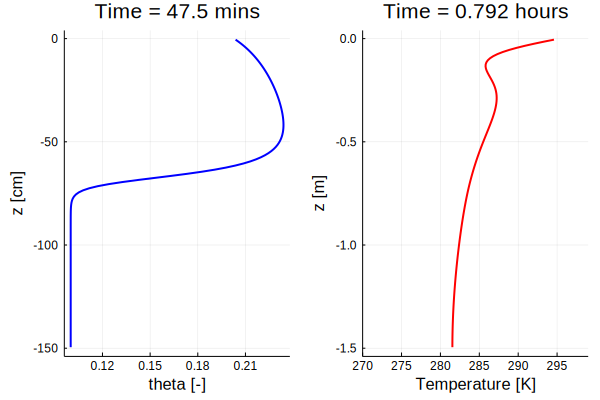

hour =    0.793 
hour =    0.794 
hour =    0.796 
hour =    0.797 
hour =    0.799 
hour =    0.800 


In [132]:
# --- Time stepping loop: NTIM iterations with a time step of DT seconds
# Solves now for both moisture and Temperature
# Initialize cumulative infiltration variables
xout = zeros(Int64.(ntim))
yout = zeros(Int64.(ntim))

for itim = 1:Int64.(ntim)

   # Hour of day
   hour = itim * (dt/86400 * 24)
   @printf("hour = %8.3f \n",hour)
    
   # Add for fun variable Boundary Condition SURFACE DRYING
    if itim > 100
        soil.theta0 = theta_sat - 1.0e-03
        if (ityp == 1)
           soil.theta0 = 0.267 - (itim-200)*0.1/ntim
        end
        soil.psi0 = matric_potential(soil.functions, params, soil.theta0)
    end


   # Calculate soil moisture
   soil = predictor_corrector(soil, params, ET, dt)
    
    # Update the soil moisure at each soil layer for the heat model
    for i = 1:soilvar.nsoi
        # Soil water at saturation [kg H2O/m2] UNITS are IMPORTANT
        soilwatercurr = soil.theta[i] * physcon.rhowat * soilvar.dz[i]
        
        # Actual water content destrinuted as liquid and ice fractions
        if (soilvar.tsoi[i] .> physcon.tfrz)
          soilvar.h2osoi_ice[i] = 0
          soilvar.h2osoi_liq[i] = soilwatercurr
        else()
          soilvar.h2osoi_liq[i] = 0
          soilvar.h2osoi_ice[i] = soilwatercurr
        end

    end

    # Top layer boundary condition
    tsurf = tmean - 0.25 * trange * sin(2*pi/24 * (hour-8.0)) # Surface temperature as sinusoidal function
    
    # Compute updated Thermal conductivity & heat capacity
    soilvar = soil_thermal_properties(physcon, soilvar)

    # Update Soil temperatures
    soilvar = soil_temperature(physcon, soilvar, tsurf, dt)
    
    # Sum fluxes for relative mass balance error()
    sum_in = sum_in + abs(soil.Q0) * dt
    sum_out = sum_out + abs(soil.QN) * dt
    sum_store = sum_store + soil.dtheta

    # Make some plots   
    if itim%10 == 0
        IJulia.clear_output(true)
        p1=plot(soil.theta,soil.z, color="blue",line=2,xlabel = "theta [-]",ylabel = "z [cm]",title="Time = "*string(round(hour*60,digits=2))*" mins")
        p2=plot(soilvar.tsoi,soilvar.z, xlim=(270,299), color="red",line=2,xlabel = "Temperature [K]",ylabel = "z [m]",title="Time = "*string(round(hour,digits=3))*" hours")
            Plots.display(plot(p1,p2,layout=(1,2),legend=false))
        sleep(0.2)
    end
        
    #print(soil.sink)

    # cumulative infiltration
    xout[itim] = hour
    yout[itim] = sum_in
    
    soilvar.tsoi

end